# Set Paths and Files

In [1]:
import sys 
sys.path.append('..')

In [2]:
import os
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random
import multiprocessing 
import time
from multiprocessing import Pool
multiprocessing.cpu_count()

import torch 
import time
import os, glob
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [3]:
MODEL_TO_LOAD = 'bonemeta_fn_0_3D_Unet_Res_lv6_PS96_nnUnet_model_epoch200'
PATCH_SIZE = (128,256,256)

# BATCH_SIZE = 120
BATCH_SIZE = 1
NUM_WORKERS = 8

BASE_DIR = '/workspace/BoneMeta_nnUnet'
IMAGE_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'labels'
PREPRED_FOLDER_NAME = '1st_pred'
PRED_FOLDER_NAME = 'preds'

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [4]:
PRED_DIR = os.path.join(BASE_DIR, PRED_FOLDER_NAME)
os.makedirs(PRED_DIR, exist_ok=True)
SAVING_DIR = os.path.join(PRED_DIR, MODEL_TO_LOAD)
os.makedirs(SAVING_DIR, exist_ok=True)
SAVING_DIR_NPY = os.path.join(SAVING_DIR, "numpy")
os.makedirs(SAVING_DIR_NPY, exist_ok=True)

In [5]:
IMAGE_DIR = os.path.join(BASE_DIR, IMAGE_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)
PREPRED_DIR = os.path.join(BASE_DIR, PREPRED_FOLDER_NAME)

IMAGE_FILES = os.listdir(IMAGE_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_image_path(file): 
    return os.path.join(IMAGE_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def get_prepred_path(file):
    return os.path.join(PREPRED_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMAGE_FILES).issubset(LABEL_FILES)

True

In [6]:
print(IMAGE_DIR, len(IMAGE_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_nnUnet/images 317
/workspace/BoneMeta_nnUnet/labels 317


In [8]:
TRAIN_FILES = ['000021_20181227_Chest_CT_(contrast).npy', '000022_20180830_Chest_CT_(contrast).npy', '000025_20180808_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000025_20180808_Chest_CT_(contrast).npy', '000080_20180911_Chest_CT_(contrast).npy', '000085_20180829_Chest_CT_(contrast).npy', '000162_20180131_Chest_CT_(contrast).npy', '000224_20190228_Chest_CT_(contrast).npy', '000234_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000234_20190419_Chest_CT_(contrast).npy', '000242_20190409_Chest_CT_(contrast).npy', '000255_20190418_Chest_CT_(contrast).npy', '000262_20190318_Chest_CT_(contrast).npy', '000262_20190319_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000262_20190529_Chest_CT_(contrast).npy', '000262_20190501_CT_Abdomen+Pelvis_Post_(contrast).npy', '000269_20190325_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000269_20181016_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000269_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000269_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000270_20190608_Chest_CT_(contrast).npy', '000276_20190604_Chest_CT_(contrast).npy', '000279_20190614_Chest_3DCT_(contrast).npy', '000281_20190701_Chest_CT_(contrast).npy', '000282_20190410_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000282_20190701_CT_Abdomen+Pelvis_Post_(contrast).npy', '000291_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000291_20190718_Chest_CT_(contrast).npy', '000296_20190726_Chest_CT_(contrast).npy', '000301_20190827_Chest_CT_(contrast).npy', '000301_20190801_CT_Acute_Abdomen_(contrast).npy', '000302_20190726_Chest_CT_(contrast).npy', '000304_20190124_CT_Liver_(contrast).npy', '000308_20190826_Chest_CT_(contrast).npy', '000309_20190801_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000309_20190823_Chest_CT_(contrast).npy', '000311_20190902_Chest_CT_(contrast).npy', '000322_20190913_Chest_CT_(contrast).npy', '000322_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000325_20190919_Chest_CT_(contrast).npy', '000330_20190926_Chest_CT_(contrast).npy', '000332_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000344_20191125_Chest_CT_(contrast).npy', '000352_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000352_20191017_Chest_CT_(contrast).npy', '000354_20191022_Chest_CT_(contrast).npy', '000354_20191001_CT_Abdomen+Pelvis_Post_(contrast).npy', '000355_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000355_20191023_Chest_CT_(contrast).npy', '000356_20190901_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000356_20191024_Chest_CT_(contrast).npy', '000362_20191214_Chest_CT_(contrast).npy', '000362_20191201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000363_20191222_Chest_3DCT_(contrast).npy', '000363_20191201_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', '000364_20191217_Chest_CT_(contrast).npy', '000368_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000372_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000376_20200114_Chest_CT_(contrast).npy', '000376_20200101_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000386_20200204_Chest_CT_(contrast).npy', '000404_20200305_Chest_CT_(contrast).npy', '000404_20200201_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', 'BH008_20190701_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH008_20190701_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Abdomen_&_pelvis_CT_(3D).npy', 'BH009_20180301_Chest_CT_(contrast)_+_3D_(TS_with_other_CT).npy', 'BH010_20161101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH010_20161101_Abdomen_&_pelvis_CT_(3D).npy', 'BH012_20180401_Abdomen_&_pelvis_CT_(3D).npy', 'BH012_20180401_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH013_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH014_20181201_Abdomen_&_pelvis_CT_(3D).npy', 'BH014_20181201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH015_20190101_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH015_20190101_Abdomen_&_pelvis_CT_(3D).npy', 'BH016_20151001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH016_20151001_Abdomen_&_pelvis_CT_(3D).npy', 'BH017_20191201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH017_20191201_Abdomen_&_pelvis_CT_(3D).npy', 'BH019_20191101_Thorax^02_Chest_CON_(Adult).npy', 'BH020_20191201_Chest_CT_(Non_contrast)_+_3D.npy', 'BH022_20190101_Thorax^03_Chest_NON_(Adult).npy', 'BH023_20191101_Abdomen_&_pelvis_CT_(3D).npy', 'BH023_20191101_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH026_20190601_Abdomen_&_pelvis_CT_(3D).npy', 'BH028_20190801_Chest_CT_(contrast)_+_3D.npy', 'BH029_20200101_Chest_HRCT_(lung_cancer).npy', 'BH031_20160301_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH032_20180701_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH034_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH034_20190923_GU_OBGY,Abd-pelvis_CT(pre&post)_(3D).npy', 'BH035_20191101_GU_Kidney_&_bladder_CT_(3D).npy', 'BH036_20180301_GU_Kidney_&_bladder_CT_(3D).npy', 'BH043_20191001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH043_20191001_Abdomen_&_pelvis_CT_(3D).npy', 'BH045_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH047_20180901_Abdomen_&_pelvis_CT_(3D).npy', 'BH048_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH051_20190301_GU_Kidney_&_bladder_CT_(3D).npy', 'BH054_20191122_Abdomen^00_Liver_CT_(Adult).npy', 'BH055_20200328_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH056_20200721_Chest_CT_(contrast)_+_3D.npy', 'BH057_20191227_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH057_20191227_Abdomen_&_pelvis_CT_(3D).npy', 'BH058_20180918_Chest_CT_(contrast)_+_3D.npy', 'BH059_20201013_Abdomen_&_pelvis_CT.npy', 'BH064_20200605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH064_20200605_Abdomen_&_pelvis_CT_(3D).npy', 'BH066_20190525_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH067_20191017_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH069_20200505_Chest_CT_(contrast)_+_3D.npy', 'BH081_20190322_Abdomen_&_pelvis_CT_(3D).npy', 'BH081_20190322_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH112_20190201_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH112_20190201_Abdomen_&_pelvis_CT_(3D).npy', 'SN002_20190801_CT_Chest_+_3D_(contr.npy', 'SN005_20191001_Abdomen^03_LIVER_(Adult).npy', 'SN005_20191101_CT_Chest_+_3D_(contr.npy', 'SN007_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', 'SN012_20150801_Abdomen^01_Abdomen_Pelvis_Chest_(Adult).npy', 'SN025_20200401_CT_Chest_+_3D_(contr.npy', 'SN028_20160801_CT_Chest_+_3D_(contrast).npy', 'SN028_20160801_CT_Abdomen+Pelvis_3D_(contrast).npy', 'SN036_20190601_CT_Chest_+_3D_(contr.npy', 'SN042_20170901_CT_Chest_+_3D_(contr.npy', 'SN042_20170901_CT_Abdomen+Pelvis_3D.npy', 'SN051_20170401_CT_Abdomen+Pelvis_Arterial+Portal_(contrast).npy', 'SN051_20170401_CT_Chest_+_3D_(contrast_NO_CM).npy', 'SN054_20170201_CT_Chest_Lung_cancer+3D(contrast).npy', 'SN055_20170301_CT_Chest_Low_Dose_+.npy']\
 + ['000010_20181214_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000370_20200101_CT_Abdomen+Pelvis_Post_(contrast).npy', '000370_20200117_Chest_CT_(contrast).npy', '000409_20200310_Chest_CT_(contrast).npy', '000409_20200301_CT_Biliary_(contrast).npy', '000417_20200331_Chest_CT_(contrast).npy', '000423_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000423_20200407_Chest_CT_(contrast).npy', '000424_20200312_Chest_CT_(noncontrast).npy', '000424_20200218_Chest_CT_(contrast).npy', '000435_20200420_Chest_CT_(contrast).npy', '000435_20200401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000466_20210125_Chest_CT_(contrast).npy', '000466_20210128_CT_Abdomen+Pelvis_Post_(contrast).npy', '000475_20210210_Chest_CT_(contrast).npy', '000481_20210305_Thorax^Lung_Pre_(Adult).npy', '000481_20200722_Chest_CT_(noncontrast).npy', '000481_20210409_CT_Liver_(contrast).npy', '000492_20210401_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', '000494_20210405_Chest_CT_(contrast).npy', '000506_20201113_Chest_CT_(contrast).npy', '000506_20201110_CT_Urography_(contrast).npy', '000528_20210514_Chest_CT_(contrast).npy', '000530_20210428_Chest_CT_(contrast).npy', '000533_20210507_CT_Liver_(contrast).npy', '000541_20210520_Chest_CT_(contrast).npy', '000557_20210621_CT_Abdomen+Pelvis_Post_(contrast).npy', '000557_20210621_Chest_CT_(contrast).npy', '000560_20210706_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000560_20210706_Chest_CT_(contrast).npy', 'BH037_20171125_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH037_20171125_Abdomen_&_pelvis_CT_(3D).npy', 'BH071_20160826_Chest_CT_(contrast)_+_3D.npy', 'BH073_20201223_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH073_20201223_Abdomen_&_pelvis_CT.npy', 'BH074_20201113_Abdomen^00_Abd_CT_(Adult).npy', 'BH075_20200721_Chest_CT_(Contrast)_+_3D(Breast).npy', 'BH076_20180605_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH076_20180605_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH078_20200522_Abdomen_&_pelvis_CT_(3D).npy', 'BH079_20200921_Low_dose_Chest_CT_+_3D(insured).npy', 'BH080_20181210_Abdomen_&_pelvis_CT_(3D).npy', 'BH082_20200416_Chest_CT_(contrast)_+_3D.npy', 'BH085_20200801_Abdomen_&_pelvis_CT.npy', 'BH086_20190812_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH087_20190314_Abdomen_&_pelvis_CT_(3D).npy', 'BH089_20200811_Abdomen_&_pelvis_CT.npy', 'BH089_20200803_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH090_20200924_Abdomen_&_pelvis_CT.npy', 'BH095_20200727_Abdomen_&_pelvis_CT_(3D).npy', 'BH098_20200626_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH098_20200626_GU_Kidney_&_bladder_CT_(3D).npy', 'BH100_20201007_Thorax^02_Chest_CON_(Adult).npy', 'BH101_20201109_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH104_20161219_Abdomen_&_pelvis_CT_(3D).npy', 'BH104_20161219_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH105_20160820_Chest_CT_(contrast)_+_3D.npy', 'BH106_20200613_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH106_20200613_Abdomen_&_pelvis_CT_(3D).npy', 'BH107_20200510_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH108_20180223_Liver_CT_(LC_or_CLD,_3D).npy', 'BH108_20180228_Chest_CT_(contrast)_+_3D.npy', 'BH109_20181210_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH111_20161020_CT_Angio_+_3D_Coronary,_Chest.npy', 'BH113_20170914_Liver_CT_(LC_or_CLD,_3D).npy', 'BH114_20180920_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH114_20180920_GU_Kidney_&_bladder_CT_(3D).npy', 'BH116_20180606_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH116_20180606_GU_Abdomen_&_pelvis_CT_(3D).npy', 'BH117_20180506_Abdomen_&_pelvis_CT_(3D).npy', 'BH117_20180506_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy', 'BH118_20200702_Chest_CT_(contrast)_+_3D.npy', 'BH119_20200303_Abdomen_&_pelvis_CT_(3D).npy', 'BH119_20200227_Chest_CT_(contrast)_+_3D.npy', 'BH120_20200406_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH120_20200406_Abdomen_&_pelvis_CT_(3D).npy', 'BH120_20200304_Chest_CT_(contrast)_+_3D.npy', 'BH121_20200301_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH121_20200301_Abdomen_&_pelvis_CT_(3D).npy', 'BH123_20201023_Abdomen_&_pelvis_CT.npy', 'BH123_20201023_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'KH001_20210501_Chest(+).npy', 'KH002_20210301_Abdomen^00_AbdomenRoutine_(Adult).npy', 'KH002_20210301_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'KH007_20200601_Chest(+).npy', 'KH007_20200601_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'KH009_20200801_Chest(+).npy', 'KH009_20200801_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'KH010_20201201_Chest(+).npy', 'KH010_20201201_Chest(+)_+_Abdomen_&_P.npy', 'KH014_20190701_Chest(+).npy', 'KH014_20190701_IM_Chest(+)_+_Abdomen_&_Pelvis_(+).npy', 'KH016_20191101_Chest(+).npy', 'KH016_20191101_Chest(+)_+_Abdomen_&_Pelvis(+).npy', 'KH023_20210901_Chest(+).npy', 'KH024_20211001_Chest(+).npy', 'KH025_20211001_Chest(+).npy', 'KH026_20210801_Chest(+).npy', 'KH027_20210801_Chest(+).npy', 'KH028_20210401_Thorax^00_Fl_Chest_Routine_(Adult).npy', 'KH030_20210901_Chest_Low-Dose_Screeni.npy', 'KH031_20210801_Chest(+).npy', 'KH032_20210701_Chest(+).npy', 'KH033_20210701_Chest(+).npy', 'KH036_20210401_Chest(+).npy', 'KH037_20210401_Chest(+).npy', 'KH038_20210401_Chest(+).npy', 'KH039_20210301_Chest_(-)_Routine.npy', 'KH040_20210301_Chest(+).npy', 'KH042_20210501_Chest(+).npy', 'KH043_20210601_Thorax^00_Fl_Chest_Routine_(Adult).npy']
VAL_FILES = ['000232_20190401_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000232_20190423_Chest_CT_(contrast).npy', '000285_20190801_CT_Abdomen+Pelvis_Pre-Post_(contrast).npy', '000285_20190807_Chest_CT_(contrast).npy', '000316_20190627_Chest_CT_(contrast).npy', '000316_20190715_Spine^L_SPINE_(Adult).npy', 'BH006_20170801_Chest_CT_(Contrast)_+_3D(Breast).npy', 'BH027_20191001_Chest_CT_(Contrast)_+_3D(TS).npy', 'BH027_20191001_L-spine_CT_(3D).npy', 'BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy', 'BH060_20200413_Chest_CT_(contrast)_+_3D.npy', 'BH062_20201104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH065_20201013_Low_dose_Chest_CT_+_3D(insured).npy', 'BH099_20200806_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH099_20200806_Abdomen_&_pelvis_CT.npy', 'BH110_20200616_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'SN004_20190901_CT_Chest_+_3D_(contrast).npy', 'SN017_20190701_Thorax^05_Chest_Lung_Cancer_3D_(Adult).npy', 'SN035_20180101_CT_Stomach+Pelvis_Arterial+Portal(contrast).npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D_(Adult).npy', '000019_20181018_Chest_CT_(contrast).npy', '000019_20190613_Chest_CT_(contrast).npy', '000019_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000193_20190114_Chest_CT_(contrast).npy', '000251_20190429_Chest_CT_(contrast).npy', '000251_20190429_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000251_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000251_20190703_Chest_CT_(contrast).npy', '000286_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000286_20190710_[외부_CT_19-07-10]Chest_CT_contrast.npy', '000288_20190701_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000450_20200528_CT_Abdomen+Pelvis_Post_(contrast).npy', '000450_20200512_Chest_CT_(contrast).npy', 'BH021_20181001_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH021_20181001_Abdomen_&_pelvis_CT_(3D).npy', 'BH024_20190501_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH024_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH052_20190901_Abdomen_&_pelvis_CT_(3D).npy', 'BH052_20190901_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'SN016_20190901_CT_Chest_+_3D_(contr.npy', 'SN016_20190901_CT_Abdomen+Pelvis_Ar.npy']
TEST_FILES = ['000011_20181207_Chest_CT_(contrast).npy', '000011_20181207_CT_Abdomen+Pelvis_Post_(contrast).npy', '000048_20190501_CT_Abdomen+Pelvis_Uro_(contrast).npy', '000069_20180319_Chest_CT_(contrast).npy', '000079_20180911_Pulmonary_artery_CT_Angio+3D_(contrast).npy', '000212_20190324_Chest_CT_(noncontrast).npy', '000260_20190501_CT_Liver_(contrast).npy', '000260_20190522_Chest_CT_(contrast).npy', '000272_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy', '000272_20190614_Chest_CT_(contrast).npy', '000278_20190620_Chest_CT_(contrast).npy', '000298_20190726_Chest_CT_(contrast).npy', '000305_20190801_CT_Acute_Abdomen_(contrast).npy', '000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy', '000400_20200210_Chest_CT_(contrast).npy', '000400_20200201_CT_Biliary_(contrast).npy', 'BH001_20190501_Abdomen_&_pelvis_CT_(3D).npy', 'BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy', 'BH005_20170701_Abdomen_&_pelvis_CT_(3D).npy', 'BH005_20170707_Chest_CT_(contrast)_+_3D_(Breast_with_other_CT).npy', 'BH007_20190801_Abdomen_&_pelvis_CT_(3D).npy', 'BH007_20190801_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH061_20190315_Abdomen_&_pelvis_CT_(3D).npy', 'BH061_20190315_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH063_20200519_Chest_CT_(Non_contrast)_+_3D(Breast).npy', 'BH070_20160823_Abdomen_&_pelvis_CT_(3D).npy', 'BH070_20160823_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy', 'BH091_20200104_GU_Kidney_&_bladder_CT_(3D).npy', 'SN019_20190801_CT_Chest_+_3D_(contr.npy', 'SN019_20190801_CT_Abdomen+Pelvis_Ar.npy', 'SN031_20160501_CT_Abdomen+Pelvis_Ar.npy', 'SN031_20160501_2-CT_Chest_Lung_cancer.npy']


# EXCEPTIONS = ['BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy'] # 모델에서 data info 만들때 가끔 오류남.
EXCEPTIONS = '''000273_20190531_Chest_CT_(contrast).npy
000439_20200624_Chest_CT_(contrast).npy
000557_20210621_Chest_CT_(contrast).npy
BH002_20190701_Chest_CT_(Non_contrast)_+_3D.npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
BH091_20200104_Chest_CT_(contrast)_+_3D_(Chest_with_other_CT).npy
000350_20191001_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000352_20191017_Chest_CT_(contrast).npy
000354_20191022_Chest_CT_(contrast).npy
000391_20200216_Thoracic_Aorta_CT_Angio+3D_(contrast).npy
BH027_20191001_L-spine_CT_(3D).npy
000270_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast).npy
000270_20190608_Chest_CT_(contrast).npy
BH040_20200101_CT_Angio_+_3D_Pulmonary_artery_(Embolism).npy
BH118_20200617_Liver_CT_(LC_or_CLD,_3D).npy'''.split('\n')

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(IMAGE_FILES)) - set(EXCEPTIONS))
VAL_FILES = list(set(VAL_FILES).intersection(set(IMAGE_FILES)) - set(EXCEPTIONS))
TEST_FILES = list(set(TEST_FILES).intersection(set(IMAGE_FILES)) - set(EXCEPTIONS))

# TRAIN_FILES = TRAIN_FILES[:50]
# VAL_FILES = VAL_FILES[:15]

In [9]:
len(TEST_FILES)

30

# Load Model

In [10]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

In [11]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D

def initModel():    
    segmentation_model = ResidualUNet3D(in_channels=3, out_channels=1, num_groups=32, f_maps=32, final_sigmoid=True, testing=True, num_levels=6)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.00005, weight_decay=0.00001)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])

# Preprocess Images

In [12]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

In [13]:
def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_image(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, padded_prepred, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    prepred_patches = padded_prepred.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    prepred_pathces = prepred_patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        prepred_batch = prepred_pathces[start:end][:,np.newaxis]
        batch = convert_to_multi_channel_image(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        batch = np.concatenate([batch, prepred_batch], axis=1)
        proccessed_batch = model(torch.tensor(batch)).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

In [14]:
def predict_one_case(image_t, prepred_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    pad_prepred = pad_for_division(prepred_t, patch_size)
    half_pad_prepred = pad_for_half(pad_prepred, patch_size)
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, pad_prepred, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, half_pad_prepred, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred

In [15]:
def getDice(prediction_g, label_g, epsilon=1):
    diceLabel_g = label_g.sum(dim=[0,1,2])
    dicePrediction_g = prediction_g.sum(dim=[0,1,2])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[0,1,2])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return diceRatio_g

In [16]:
def savePred(pred_t, filename):
    file_path = os.path.join(SAVING_DIR_NPY, filename)
    np.save(file_path, pred_t.numpy().astype(np.uint8))
    
def saveLog(log_string):
    with open(f'{SAVING_DIR}/log.txt', 'w') as f:
        f.write(log_string)

In [17]:
def doPrediction(files, batch_size, patch_size):
    dice_metric = np.zeros(len(files))
    log_text =''
    for i, file in enumerate(files):
        image = np.load(get_image_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        label = label > 0.5 # 현재 label이 1,2,3 으로 마스킹이 다르게 되어있음
        prepred = np.load(get_prepred_path(file))
        prepred_t = torch.tensor(prepred)
        
        pred = predict_one_case(image_t, prepred_t, batch_size, patch_size)
        pred_t = pred>0.5
        label_t = torch.tensor(label)
        
        dice = getDice(pred_t, label_t, epsilon=0.01)
        dice_sig = getDice(pred, label_t, epsilon=0.01)
        
        dice_metric[i] = dice
        
        log = f"""
Case: {file_to_case(file)}
    DICE = {dice}
    DICE with sigmoid = {dice_sig}
    """
        print(log)
        log_text = log_text + log
        savePred(pred_t, file)
        
    log = f'''
Average DICE score = {dice_metric.mean()}
Standard deviation = {dice_metric.std()}
DICE = {list(dice_metric)}
    '''
    log_text = log_text + log
    saveLog(log_text)
    print(log)
    return dice_metric

In [18]:
t = time.perf_counter()

dice = doPrediction(TEST_FILES, BATCH_SIZE, PATCH_SIZE)
    
elapsed_time = time.perf_counter() - t
print(f'Time consumed: {elapsed_time}s')




Case: BH063_20200519_Chest_CT_(Non_contrast)_+_3D(Breast)
    DICE = 0.5067163705825806
    DICE with sigmoid = 0.4239579141139984
    

Case: 000298_20190726_Chest_CT_(contrast)
    DICE = 0.5017378926277161
    DICE with sigmoid = 0.20526228845119476
    

Case: 000400_20200210_Chest_CT_(contrast)
    DICE = 0.3230445981025696
    DICE with sigmoid = 0.07446286827325821
    

Case: BH001_20190501_Abdomen_&_pelvis_CT_(3D)
    DICE = 0.5034672617912292
    DICE with sigmoid = 0.38466963171958923
    

Case: BH005_20170701_Abdomen_&_pelvis_CT_(3D)
    DICE = 0.22780202329158783
    DICE with sigmoid = 0.21946974098682404
    

Case: BH061_20190315_Abdomen_&_pelvis_CT_(3D)
    DICE = 0.36793315410614014
    DICE with sigmoid = 0.35931500792503357
    

Case: 000272_20190601_CT_Abdomen+Pelvis_Dynamic_(contrast)
    DICE = 0.6099314093589783
    DICE with sigmoid = 0.5723303556442261
    

Case: 000278_20190620_Chest_CT_(contrast)
    DICE = 0.5329282283782959
    DICE with sigmoid = 0.42

(array([2., 0., 3., 0., 6., 1., 5., 5., 3., 5.]),
 array([1.77872334e-06, 7.86064302e-02, 1.57211082e-01, 2.35815733e-01,
        3.14420384e-01, 3.93025036e-01, 4.71629687e-01, 5.50234339e-01,
        6.28838990e-01, 7.07443642e-01, 7.86048293e-01]),
 <BarContainer object of 10 artists>)

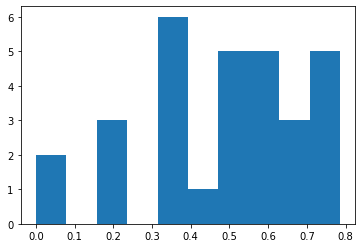

In [29]:
plt.hist(dice)

# Show an Example

In [19]:
import matplotlib.pyplot as plt

def slice_image(image, offset, end, interval):
  if end is None:
    end = len(image)
  else: 
    if end > len(image): 
      end = len(image)
    if end <= offset:
      end = offset + 1
  return image[offset:end:interval]

def show_numpy_image(np_image, offset=0, end=None, interval=5, title=''): 
  sliced_image = slice_image(np_image, offset, end, interval)

  figsize_per_image = 3
  num_col = 5
  num_row = int(np.ceil(sliced_image.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_image*num_col, figsize_per_image*num_row))
  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))
  for i, image in enumerate(sliced_image):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(image)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(image, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_image_info(np_image):
  print('Shape:', np_image.shape)
  print('DType:', np_image.dtype)
  print('Max:', np_image.max())
  print('Min:', np_image.min())
  print(np_image)


#npy image, npy label 
def plot_image_and_label(np_image, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_image = slice_image(np_image, offset, end, interval)
  sliced_label = slice_image(label, offset, end, interval)
  
  num_row = len(sliced_image)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_image[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [20]:
def plot_image_label_pred(image_npy, label_npy, pred_npy, interval = 5, offset = 0, end=None, figsize_per_image = 5, show_only_positive = False):
    sliced_image = slice_image(image_npy, offset, end, interval)
    sliced_label = slice_image(label_npy, offset, end, interval)
    sliced_pred = slice_image(pred_npy, offset, end, interval)

    if show_only_positive:
        positive_idx = (sliced_label + sliced_pred).sum(axis = (1,2)) > 0.5
        sliced_image = sliced_image[positive_idx]
        sliced_label = sliced_label[positive_idx]
        sliced_pred = sliced_pred[positive_idx]
    
    num_row = len(sliced_image)
    num_col = 3
    
    plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

    for i in range(0, num_row):
        plt.subplot(num_row, num_col, i*num_col+1)
        tissue_image = sliced_image[i]
        plt.imshow(tissue_image, 'gray')

        plt.subplot(num_row, num_col, i*num_col+2)
        mask = sliced_label[i]
        label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
        plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')
        
        plt.subplot(num_row, num_col, i*num_col+3)
        mask = sliced_pred[i]
        pred_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(255,0,0))
        plt.imshow(sitk.GetArrayFromImage(pred_on_tissue), 'gray')

    plt.tight_layout()
    plt.show()

In [62]:
sample_file = '000260_20190501_CT_Liver_(contrast).npy'

In [63]:
image = np.load(get_image_path(sample_file))
image_t = torch.tensor(image)

label = np.load(get_label_path(sample_file))
label = label > 0.5 # 현재 label이 1,2,3 으로 마스킹이 다르게 되어있음

prepred = np.load(get_prepred_path(sample_file))
prepred_t = torch.tensor(prepred)

pred = predict_one_case(image_t, prepred_t, BATCH_SIZE, PATCH_SIZE)
pred_t = pred > 0.5


In [64]:
%matplotlib inline

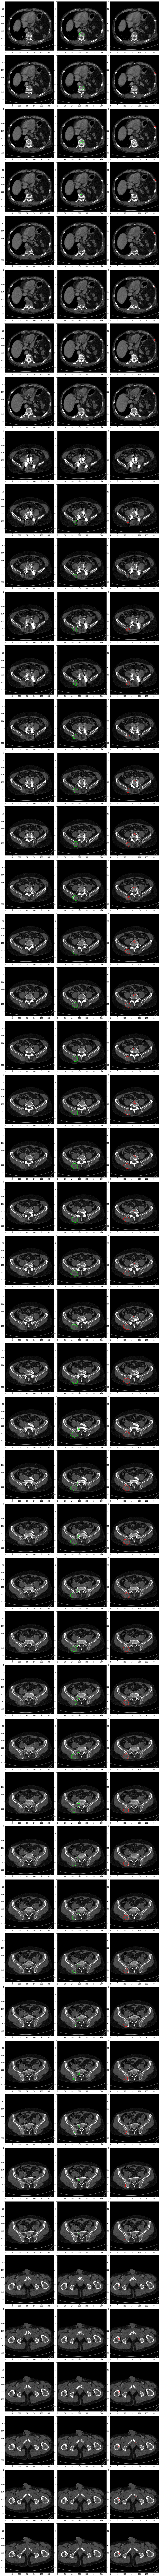

In [65]:
plot_image_label_pred((adjust_window(image,(700,200))*255).astype(np.uint8), label.astype(np.uint8), pred_t.numpy().astype(np.uint8), show_only_positive = True, interval =2)